In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random
import sys

import csv
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.model_selection import train_test_split, cross_val_score

from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re   
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-01-27 09:58:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-27 09:58:45--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-27 09:58:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

device = 'cpu'
print('Working on:', device)

Working on: cpu


In [ ]:
def normalize_review(review):
    #normalize data
    # Remove hashtags
    res = re.sub(r'(#)(#)*(\w)*', '', review)
    # Remove all punctuations and special characters
    res = re.sub(r'[^\w\s]', '', res)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets_tokenized = []
    review_words = []
    word_tokens = word_tokenize(res)
    for word in word_tokens:
        lemmatized_word = lemmatizer.lemmatize(word)
        review_words.append(lemmatized_word)
    res =  (' '.join([str(elem) for elem in review_words]).lower())
    return res


In [ ]:
my_test= None    # Please enter your dataframe here like this my_test = pd.read_csv('/content/drive/MyDrive/AI2/imdb-reviews.csv', sep='\t')
if(not (my_test is  None)):
    my_test = pd.read_csv('/content/drive/MyDrive/AI2/imdb-reviews.csv', sep='\t')
    my_test['review'] = my_test['review'].apply(normalize_review)
    my_test.loc[my_test['rating'] <=4 , 'rating'] = 0   #if your dataframe already has ratings in binary form please comment out these two lines 
    my_test.loc[my_test['rating'] >= 7, 'rating'] = 1


  


In [ ]:
    df1 = pd.read_csv('/content/drive/MyDrive/AI2/imdb-reviews.csv', sep='\t')
    df1['review'] = df1['review'].apply(normalize_review)
    df1.loc[df1['rating'] <=4 , 'rating'] = 0
    df1.loc[df1['rating'] >= 7, 'rating'] = 1
    print(len(df1))
   

45008


In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = '/content/drive/MyDrive/AI2/glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

In [ ]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

In [ ]:

#creating w2v
review_vector=[]
for review in df1["review"]:
  k=0.0
  rev_vector=0
  for word in review.split():
    if word in model.vocab:
      k+=1.0
      rev_vector+=model[word]
  if(k!=0.0):
    rev_vector/=k #dividing the sum of the words by k (the words from the review wich exist in the model's vocab)
    review_vector.append(rev_vector)
  else:
    rev_vector=[0]*model.vector_size #initializing an array of 0 in case no word of the  model appears in review
    review_vector.append(rev_vector)

print(len(review_vector))

      

45008


In [ ]:
revs=review_vector
rt=df1[["rating"]]

if my_test is None:
  x_train, x_test, y_train, y_test = train_test_split(revs, rt, test_size=0.15)
else:
    x_train=revs
    y_train=rt
    y_test=my_test["rating"]
    review_test_vector=[]
    for review in my_test["review"]: #converting your data to w2v as well
      k=0.0
      rev_vector=0
      for word in review.split():
        if word in model.vocab:
          k+=1.0
          rev_vector+=model[word]
      if(k!=0.0):
        rev_vector/=k
        review_test_vector.append(rev_vector)
      else:
        rev_vector=[0]*model.vector_size
        review_test_vector.append(rev_vector)
    x_test= review_test_vector
    print(len(x_test))





In [ ]:

# print(test_x.shape, test_y.shape)
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_p=0.1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = nn.GRU(input_size, hidden_size, num_layers, batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.layer_num = 1

    def forward(self, x):
        dot_product = torch.bmm(x, x.transpose(1, 2))  #attention function
        dot_product = dot_product / (300 ** 0.5)
        attention_weights = F.softmax(dot_product, dim=2)
        x = torch.bmm(attention_weights, x)
        out, _ = self.cell_type(x)
        if self.layer_num % 2 == 1 and self.layer_num != 1: #skiping connections adding layer 1 to 3 and 3 to 5  
            out[:, :, self.layer_num-1] += out[:, :, self.layer_num-3]
        elif self.layer_num != 2: #skiping connections adding layer 2 to 4 a 
            out[:, :, self.layer_num-1] += out[:, :, self.layer_num-3]
        out = out[:, -1]
        out = self.dropout(out)
        out = self.fc(out)
        return out


    def clip_gradients(self, clip_norm):
        torch.nn.utils.clip_grad_norm_(self.parameters(), clip_norm)
# Define the model parameters
input_size = 300
hidden_size = 300

num_layers = 5
num_classes = 2

# Initialize the model
model = RNN(input_size, hidden_size, num_layers, num_classes)
learning_rate = 1e-4
# Define the loss function and optimizer
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


# Convert x_train and x_test to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)



# Create tensors from the numpy arrays
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()

y_train = np.array(y_train)
y_test = np.array(y_test)

# convert y_train and y_test to tensors
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
dataset = TensorDataset(x_train, y_train)
dataset2 = TensorDataset(x_test, y_test)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

dataloader2=DataLoader(dataset2,batch_size=128,shuffle=True)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Train the model for a chosen number of epochs
train_accuracies = []
train_losses = []
num_epochs = 15
for epoch in range(num_epochs):
    for data in dataloader:
        for i in range(num_layers):
          x_batch, y_batch = data
          x_batch= x_batch.view(-1,1, 300)
          model.layer_num=i+1
          output = model(x_batch)
          y_batch = y_batch.view(-1)
          y_batch=y_batch.long()
          loss = criterion(output, y_batch)
          optimizer.zero_grad()
          loss.backward()
          model.clip_gradients(clip_norm=1.0) #clipping gradients
          optimizer.step()
    _, predicted = torch.max(output.data, 1) #getting the positive numv=ber
    acc = (predicted == y_batch).sum().item() / len(y_batch)
    train_accuracies.append(acc)
    train_losses.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss.item(), acc))

Epoch [1/15], Loss: 0.3635, Accuracy: 0.7857
Epoch [2/15], Loss: 0.4118, Accuracy: 0.8125
Epoch [3/15], Loss: 0.3226, Accuracy: 0.8661
Epoch [4/15], Loss: 0.3409, Accuracy: 0.8661
Epoch [5/15], Loss: 0.4066, Accuracy: 0.8125
Epoch [6/15], Loss: 0.3636, Accuracy: 0.8571
Epoch [7/15], Loss: 0.3515, Accuracy: 0.8661
Epoch [8/15], Loss: 0.4392, Accuracy: 0.8125
Epoch [9/15], Loss: 0.4028, Accuracy: 0.8304
Epoch [10/15], Loss: 0.4174, Accuracy: 0.8214
Epoch [11/15], Loss: 0.3475, Accuracy: 0.8482
Epoch [12/15], Loss: 0.3229, Accuracy: 0.8661
Epoch [13/15], Loss: 0.3939, Accuracy: 0.8125
Epoch [14/15], Loss: 0.4227, Accuracy: 0.8125
Epoch [15/15], Loss: 0.3386, Accuracy: 0.8214


In [ ]:
#same procedure for validation set
num_epochs = 15
val_accuracies = []
val_losses=[]
for epoch in range(num_epochs):
    for data in dataloader2:
        x_batch, y_batch = data
        x_batch= x_batch.view(-1, 1, 300)
        output = model(x_batch)
        y_batch = y_batch.view(-1)
        y_batch=y_batch.long()
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        model.clip_gradients(clip_norm=1.0)
        optimizer.step()
    _, predicted = torch.max(output.data, 1)
    acc = (predicted == y_batch).sum().item() / len(y_batch)
    val_accuracies.append(acc)
    val_losses.append(loss.item())
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, num_epochs, loss.item(), acc))

Epoch [1/15], Loss: 0.3348, Accuracy: 0.8646
Epoch [2/15], Loss: 0.4305, Accuracy: 0.7917
Epoch [3/15], Loss: 0.4287, Accuracy: 0.8021
Epoch [4/15], Loss: 0.3541, Accuracy: 0.8125
Epoch [5/15], Loss: 0.3659, Accuracy: 0.8646
Epoch [6/15], Loss: 0.2510, Accuracy: 0.8958
Epoch [7/15], Loss: 0.3471, Accuracy: 0.8854
Epoch [8/15], Loss: 0.2754, Accuracy: 0.8958
Epoch [9/15], Loss: 0.2943, Accuracy: 0.8958
Epoch [10/15], Loss: 0.3645, Accuracy: 0.8229
Epoch [11/15], Loss: 0.3909, Accuracy: 0.8229
Epoch [12/15], Loss: 0.2574, Accuracy: 0.9167
Epoch [13/15], Loss: 0.2586, Accuracy: 0.8958
Epoch [14/15], Loss: 0.3261, Accuracy: 0.8125
Epoch [15/15], Loss: 0.4362, Accuracy: 0.8229


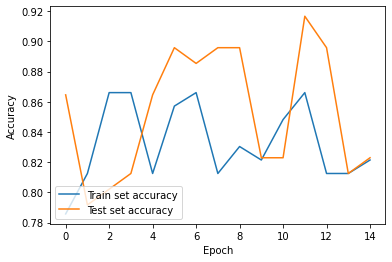

In [ ]:
# Plot the learning curve
plt.plot(train_accuracies, label='Train set accuracy')
plt.plot(val_accuracies, label='Test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.show()

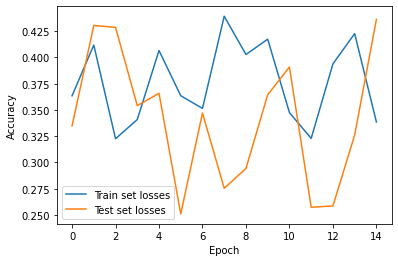

In [ ]:
#plotting accuracy per epoch on both sets
plt.plot(train_losses, label='Train set losses')
plt.plot(val_losses, label='Test set losses')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score,recall_score
import matplotlib.pyplot as pltS

with torch.no_grad():
    model.eval()
    x_test = x_test.view(-1, 1, 300)
    y_pred = model(x_test) # make predictions on the test set
    y_pred = y_pred.view(-1, num_classes) # reshape the output tensor
    y_pred = y_pred.argmax(dim=1) # find the index of the maximum value in each output
    y_pred = y_pred.cpu().numpy() # convert the predictions to numpy array
    y_test = y_test.cpu().numpy() # convert the labels to numpy array
    accuracy = accuracy_score(y_test, y_pred) # calculate the accuracy
    precision = precision_score(y_test, y_pred) # calculate the precision
    recall = recall_score(y_test,y_pred)
    f1 = f1_score(y_test, y_pred) # calculate the f1-score
    # Calculate ROC AUC score and ROC curve for test set
    val_roc_auc = roc_auc_score(y_test, y_pred)
    fpr_val, tpr_val, _ = roc_curve(y_test, y_pred)
    print("Test Set Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}".format(accuracy, precision,recall, f1))

Test Set Accuracy: 0.8495 Precision: 0.8458 Recall: 0.8597 F1-Score: 0.8527


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve,accuracy_score,recall_score
import matplotlib.pyplot as plt

   
with torch.no_grad():
    model.eval()
    x_train = x_train.view(-1, 1, 300)
    y_pred_train = model(x_train) # make predictions on the train set
    y_pred_train = y_pred_train.view(-1, num_classes) # reshape the output tensor
    y_pred_train = y_pred_train.argmax(dim=1) # find the index of the maximum value in each output
    y_pred_train = y_pred_train.cpu().numpy() # convert the predictions to numpy array
    y_train = y_train.cpu().numpy() # convert the labels to numpy array
    accuracy_train = accuracy_score(y_train, y_pred_train) # calculate the accuracy for train set
    precision_train = precision_score(y_train, y_pred_train) # calculate the precision for train set
    recall_train = recall_score(y_test,y_pred)
    f1_train = f1_score(y_train, y_pred_train) # calculate the f1-score for train set
    # Calculate ROC AUC score and ROC curve for train set
    train_roc_auc = roc_auc_score(y_train, y_pred_train)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)

    print("Train Set Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}".format(accuracy_train, precision_train,recall_train, f1_train))


Train Set Accuracy: 0.8470 Precision: 0.8359 Recall: 0.8597 F1-Score: 0.8490


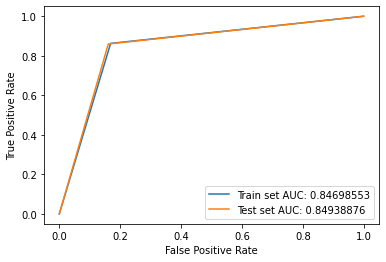

In [ ]:

# Plot the ROC curves
plt.plot(fpr_train, tpr_train, label='Train set AUC: {:.8f}'.format(train_roc_auc))
plt.plot(fpr_val, tpr_val, label='Test set AUC: {:.8f}'.format(val_roc_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
#tried this code given to try to save the model 
# the model is included to the zip
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('myNN.pt') # Save
model = torch.jit.load('myNN.pt')
model.eval()

RecursiveScriptModule(
  original_name=RNN
  (cell_type): RecursiveScriptModule(original_name=GRU)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc): RecursiveScriptModule(original_name=Linear)
)